# ===============================================
# Video Stutter Detection Notebook
# このノートブックは動画のカクつき（stutter）を検出・解析するための実験用です
# 実行環境（カーネル）はTestProg_video（Python 3.8.19）で行ってください
# ===============================================

In [8]:
# 必要なライブラリをインポート
import cv2          # OpenCV: 動画読み込み・画像処理用
import numpy as np  # 数値計算・配列処理用
import matplotlib.pyplot as plt  # 可視化用
import os         # ファイル操作用
import tkinter as tk # GUI用
from tkinter import ttk # GUI用
import time # 時間計測用
import shutil #  # ファイル操作用
import threading # スレッド用
import queue # キューイング用
import argparse     # コマンドライン引数解析用
from concurrent.futures import ThreadPoolExecutor # 並列処理用

In [9]:
# -----------------------------------------------
# list_video_devices 関数 (利用可能ビデオキャプチャデバイス一覧取得関数)
# -----------------------------------------------
"""
概要:
    接続されているビデオキャプチャデバイス（Webカメラなど）を探索し、
    利用可能なデバイス番号と識別名のリストを返す関数。
    この関数を使用することで、ユーザーが利用可能なカメラデバイスを選択可能になる。
    
引数:
    max_devices (int, optional): チェックする最大デバイス番号。デフォルトは10。
    
戻り値:
    devices (list of tuples): 利用可能なデバイスのリスト。
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]
        
注意:
    - デバイスマネージャーのカメラでTriforaなど特定のドライバを認識している場合、正常に認識できないことがあります。
    - cv2.VideoCapture() は番号順にデバイスを開くため、接続順序によって番号が変わることがあります。
"""
def list_video_devices(max_devices=10, timeout=1.0):
    devices = []

    def try_open_device(idx, result_dict):
        try:
            cap = cv2.VideoCapture(idx, cv2.CAP_DSHOW)
            if cap.isOpened():
                result_dict["opened"] = True
            cap.release()
        except Exception as e:
            print(f"デバイス {idx} は無視されました: {e}")
            result_dict["opened"] = False

    for idx in range(max_devices):
        result = {"opened": False}
        t = threading.Thread(target=try_open_device, args=(idx, result))
        t.start()
        t.join(timeout=timeout)  # タイムアウト待ち
        if t.is_alive():
            print(f"デバイス {idx} はタイムアウト ({timeout} 秒) によりスキップされました")
        elif result["opened"]:
            devices.append((idx, f"Camera {idx}"))

    return devices


# 実行例
if __name__ == "__main__":
    print("利用可能なビデオキャプチャデバイス:")
    devices = list_video_devices(max_devices=10, timeout=1.0)
    for idx, name in devices:
        print(f"デバイス番号: {idx}, 名前: {name}")


利用可能なビデオキャプチャデバイス:
デバイス番号: 0, 名前: Camera 0
デバイス番号: 1, 名前: Camera 1
デバイス番号: 0, 名前: Camera 0
デバイス番号: 1, 名前: Camera 1


In [10]:
# -----------------------------------------------
# launch_gui 関数 (ビデオデバイス選択GUI関数)
# -----------------------------------------------
"""
概要:
    ユーザーが接続されているビデオキャプチャデバイスの中から1つを選択できるGUIを表示し、
    選択されたデバイス番号を返す関数。

引数:
    devices (list of tuples): list_video_devices などで取得した利用可能なデバイスのリスト
        例: [(0, 'Camera 0'), (1, 'Camera 1'), ...]

戻り値:
    int or None: 選択されたデバイス番号
        - ユーザーが選択して「開始」を押した場合は選択番号を返す
        - GUIを閉じるなど何も選ばなかった場合は None を返す

注意:
    - combo.current(0) により、デフォルトで最初のデバイスが選択される
    - GUIを閉じただけで何も選ばなかった場合は None になる
"""
def launch_gui(devices):
    selected_device = {"idx": None}  # 辞書で共有変数

    root = tk.Tk()
    root.title("デバイス選択")
    tk.Label(root, text="使用するデバイスを選択:").pack(pady=5)

    display_names = [f"{name} (番号: {idx})" for idx, name in devices]
    device_var = tk.StringVar()
    combo = ttk.Combobox(root, textvariable=device_var, values=display_names, state="readonly")
    combo.current(0)
    combo.pack(pady=5)

    def on_start():
        selected_device["idx"] = devices[combo.current()][0]
        root.destroy()

    tk.Button(root, text="開始", command=on_start).pack(pady=10)
    root.mainloop()

    return selected_device["idx"]

In [11]:
# -----------------------------------------------
# start_capture 関数 (デスクトップ一時保存型・FPS制限付きメモリ節約ビデオキャプチャ関数)
# -----------------------------------------------
"""
概要:
    指定したビデオキャプチャデバイスから映像を取得し、
    フレームを一時ファイルとしてデスクトップ上に保存することでメモリ使用量を抑える関数。
    同時に簡易表示として低FPS（デフォルト10FPS）で画面に映像を表示できる。
    高FPSでの表示による負荷を軽減する用途に適している。

引数:
    device_number (int): キャプチャ対象のデバイス番号（list_video_devices で取得した番号）
    max_frames (int or None): 最大フレーム数。Noneの場合は制限なし
    width (int): キャプチャ解像度の幅（デフォルト 720）
    height (int): キャプチャ解像度の高さ（デフォルト 480）
    capture_fps (int): キャプチャ時のフレームレート（デフォルト 60）
    display_fps (int): imshow 表示のフレームレート（デフォルト 10）

戻り値:
    frame_count (int): 保存したフレームの総数
    stutter_frames (list): カクつき検出用フレームリスト（メモリ軽量化のため空リスト）
    actual_fps (float): 実際のキャプチャFPS（全フレーム読み込み時間から計算）

注意:
    - フレームはデスクトップ上の "temp_frames" フォルダに保存される
    - 'q' キーでユーザーが任意にキャプチャを終了できる
    - imshow は低FPSに固定して表示負荷を軽減している

解像度：
    要求: 1920x1080 @ 15fps → 実際: 1920x1080 @ 15fps
    要求: 1920x1080 @ 30fps → 実際: 1920x1080 @ 30fps
    要求: 1920x1080 @ 60fps → 実際: 1920x1080 @ 60fps
    要求: 1920x1080 @ 120fps → 実際: 1920x1080 @ 60fps
    要求: 1280x720 @ 15fps → 実際: 1280x720 @ 15fps
    要求: 1280x720 @ 30fps → 実際: 1280x720 @ 30fps
    要求: 1280x720 @ 60fps → 実際: 1280x720 @ 60fps
    要求: 1280x720 @ 120fps → 実際: 1280x720 @ 60fps
    要求: 640x480 @ 15fps → 実際: 720x480 @ 15fps
    要求: 640x480 @ 30fps → 実際: 640x480 @ 30fps
    要求: 640x480 @ 60fps → 実際: 640x480 @ 60fps
    要求: 640x480 @ 120fps → 実際: 640x480 @ 60fps

注意：
    1. cv2.imshowの更新制限
     cv2.imshow() は高fps動画表示用に最適化されていません。
     cv2.waitKey(30) の 引数 30ms が「表示更新の最小待ち時間」になっていて、これだと 理論上 1000 ÷ 30 ≈ 33fps しか出ません。
     → だから、たとえカメラから 60fps でフレームが来ていても、表示は 30fps 付近に制限されます。
    2. キャプチャと表示は別物
     OpenCVの cap.read() ではちゃんと 60fps でフレームが取得されている可能性があります。
     でも imshow の表示はGUIの制限を受けるので、見た目は30fps程度に落ちて見えるんです。
"""
def start_capture(device_number, max_frames=None, width=720, height=480, capture_fps=60, display_fps=10):
    # メモリ節約用一時フォルダ(フォルダ名：temo_frames)をデスクトップ上に作成
    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    temp_folder = os.path.join(desktop, "temp_frames")

    # 既に存在する場合はフォルダごと削除
    if os.path.exists(temp_folder):
        shutil.rmtree(temp_folder)
    
    # フォルダを再作成
    os.makedirs(temp_folder, exist_ok=True)

    print(f"{temp_folder} を空の状態で作成しました。")
    
    # ビデオキャプチャの初期化
    cap = cv2.VideoCapture(device_number, cv2.CAP_DSHOW)
    if not cap.isOpened():
        print("Error: キャプチャデバイスを開けませんでした")
        return 0, [], 0
    
    # 解像度とフレームレートの設定
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    cap.set(cv2.CAP_PROP_FPS, capture_fps)

    # フレーム読み込みループ
    frame_count = 0
    print("映像キャプチャ開始。'q'キーで終了できます。")

    # パフォーマンス計測用
    start_time = time.time()
    prev_display_time = start_time
    display_interval = 1.0 / display_fps

    # フレーム読み込みループ
    while cap.isOpened(): # キャプチャが開いている間
        ret, frame = cap.read()
        if not ret:
            break

        # メモリ節約: フレームを一時ファイルとして保存
        frame_file = os.path.join(temp_folder, f"frame_{frame_count:05d}.png") # ゼロ埋め5桁の整数
        cv2.imwrite(frame_file, frame) # OpenCVの関数で、画像をファイルとして保存
        frame_count += 1 # 保存したフレーム数をカウントアップ

        # 指定した表示FPSでimshowを更新 動作確認用動作を表示
        curr_time = time.time()
        dt = curr_time - prev_display_time
        if dt >= display_interval:
            fps_display = 1.0 / dt if dt > 0 else 0
            prev_display_time = curr_time
            display_frame = frame.copy()
            cv2.putText(display_frame, f"Display FPS: {fps_display:.2f}", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.imshow("For testing purposes *FPS is fixed at 10 to reduce load", display_frame)

        # 'q'キーで終了
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("ユーザーによる終了")
            break

        # 最大フレーム数に達したら終了
        if max_frames is not None and frame_count >= max_frames:
            print(f"最大フレーム数 {max_frames} に到達")
            break

    # キャプチャ終了
    end_time = time.time()
    cap.release()
    cv2.destroyAllWindows()

    # 実際のFPS計算
    total_time = end_time - start_time
    actual_fps = frame_count / total_time if total_time > 0 else 0

    # 結果表示
    print(f"{frame_count} フレームをキャプチャしました（実際のFPS: {actual_fps:.2f}）")
    print(f"フレームは {temp_folder} に保存されました")

    # メモリ軽量化のため stutter_frames は空リスト
    stutter_frames = []
    
    return frame_count, stutter_frames, actual_fps

In [12]:
# -----------------------------------------------
# detect_stutter 関数（閾値以下で時間 >= min_time_diff 秒ならカクつき判定）
# -----------------------------------------------
"""
frames: フレームリスト
fps: 映像のフレームレート（1秒あたりのフレーム数）
threshold: 差分ピクセル数の閾値（これ以下でカクつき判定）
min_time_diff: 連続して閾値以下の時間（秒）がこの値以上ならカクつきと判定
output_folder: カクつきフレームを保存するフォルダ
               None の場合はデスクトップに "stutter_frames" を作成
戻り値:
    stutter_frames: カクつきフレーム番号のリスト
    temp_folder: 一時ファイルを保存したフォルダ
                 ファイル名は 'frame_00001.png' のようになっている前提
    fps: キャプチャ時のフレームレート
    threshold: 差分ピクセル数の閾値
    min_time_diff: これ秒未満の連続差分はカクつき判定から除外
    output_folder: カクつきフレームを保存するフォルダ
                   Noneの場合はデスクトップに 'stutter_frames' を作成
"""
def detect_stutter_auto_threshold(temp_folder, fps=60, min_time_diff=0.1, output_folder=None, threshold_method='std', k=2.0):
    """
    threshold_method: 'std' または 'median' で自動計算方法を選択
    k: 標準偏差や中央値の倍率（カクつきとみなすかの感度）
    """
    if output_folder is None:
        # カクツキ時の画像キャプチャ保管フォルダ(フォルダ名：stutter_frames)をデスクトップ上に作成
        desktop = os.path.join(os.path.expanduser("~"), "Desktop")
        output_folder = os.path.join(desktop, "stutter_frames")

    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)
    print(f"{output_folder} を空の状態で作成しました。")

    frame_files = sorted([f for f in os.listdir(temp_folder) if f.endswith('.png')])
    if not frame_files:
        print("フレームが見つかりません。")
        return []

    stutter_frames = []
    temp_stutter_indices = []
    min_frame_diff = int(min_time_diff * fps)

    # 前フレームを読み込む
    prev_frame = cv2.imread(os.path.join(temp_folder, frame_files[0]), cv2.IMREAD_GRAYSCALE)

    # 差分を計算してリスト化
    diff_values = []
    for fname in frame_files[1:]:
        curr_frame = cv2.imread(os.path.join(temp_folder, fname), cv2.IMREAD_GRAYSCALE)
        diff = cv2.absdiff(curr_frame, prev_frame)
        non_zero_count = np.count_nonzero(diff)
        diff_values.append(non_zero_count)
        prev_frame = curr_frame
        del curr_frame, diff

    # 自動しきい値計算
    diff_array = np.array(diff_values)
    if threshold_method == 'std':
        threshold = np.mean(diff_array) - k * np.std(diff_array)
    elif threshold_method == 'median':
        threshold = np.median(diff_array) - k * np.std(diff_array)
    else:
        raise ValueError("threshold_method は 'std' か 'median' を指定してください。")
    threshold = max(threshold, 0)  # 負にならないように

    print(f"自動計算された差分しきい値: {threshold:.2f}")

    # 判定ループ（再度フレームを読み込む必要あり）
    prev_frame = cv2.imread(os.path.join(temp_folder, frame_files[0]), cv2.IMREAD_GRAYSCALE)
    for i, fname in enumerate(frame_files[1:], start=1):
        curr_frame = cv2.imread(os.path.join(temp_folder, fname), cv2.IMREAD_GRAYSCALE)
        diff = cv2.absdiff(curr_frame, prev_frame)
        non_zero_count = np.count_nonzero(diff)

        if non_zero_count <= threshold:
            temp_stutter_indices.append(i)
        else:
            if len(temp_stutter_indices) >= min_frame_diff:
                stutter_frames.extend(temp_stutter_indices)
                for idx in temp_stutter_indices:
                    save_indices = [max(idx-1,0), idx, min(idx+1,len(frame_files)-1)]
                    for sidx in save_indices:
                        src = os.path.join(temp_folder, frame_files[sidx])
                        dst = os.path.join(output_folder, f"stutter_{frame_files[sidx]}")
                        shutil.copy(src, dst)
            temp_stutter_indices = []

        prev_frame = curr_frame
        del curr_frame, diff

    # 最後の残りも処理
    if len(temp_stutter_indices) >= min_frame_diff:
        stutter_frames.extend(temp_stutter_indices)
        for idx in temp_stutter_indices:
            save_indices = [max(idx-1,0), idx, min(idx+1,len(frame_files)-1)]
            for sidx in save_indices:
                src = os.path.join(temp_folder, frame_files[sidx])
                dst = os.path.join(output_folder, f"stutter_{frame_files[sidx]}")
                shutil.copy(src, dst)

    print(f"{len(stutter_frames)} フレームがカクつきとして検出され、前後も含めて {output_folder} に保存されました。")
    return stutter_frames

In [13]:
# -----------------------------------------------
# 可視化関数（時間軸と差分値で表示）
# -----------------------------------------------
"""
frames: 読み込んだ動画フレームのリスト
stutter_frames: カクつきと検出されたフレーム番号のリスト
fps: フレームレート（デフォルト30fps）

横軸: 時間（秒）
縦軸: フレーム間差分の値
"""
def plot_stutter(frames, stutter_frames, fps=60):
    if not frames or not stutter_frames:
        print("フレームまたはカクつきフレームが存在しないため、可視化はスキップします。")
        return

    # 前フレームとの差分を計算して数値化
    diff_values = [0]  # 1フレーム目は比較できないので0
    for i in range(1, len(frames)):
        diff = cv2.absdiff(frames[i], frames[i-1])
        diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        diff_values.append(np.count_nonzero(diff_gray))

    # 横軸を時間に変換
    times = np.arange(len(diff_values)) / fps

    plt.figure(figsize=(12, 5))
    plt.plot(times, diff_values, label="Frame difference")
    
    # カクつきフレームを赤で表示
    stutter_times = np.array(stutter_frames) / fps
    stutter_diff = [diff_values[i] for i in stutter_frames]
    plt.scatter(stutter_times, stutter_diff, color='red', label="Stutter frames")

    plt.title('Video Stutter Detection')
    plt.xlabel('Time (s)')
    plt.ylabel('Frame Difference (Non-zero pixels)')
    plt.legend()
    plt.show()

選択されたデバイス番号: 0
C:\Users\HP_PC\Desktop\temp_frames を空の状態で作成しました。
映像キャプチャ開始。'q'キーで終了できます。
ユーザーによる終了
393 フレームをキャプチャしました（実際のFPS: 59.42）
フレームは C:\Users\HP_PC\Desktop\temp_frames に保存されました
C:\Users\HP_PC\Desktop\stutter_frames を空の状態で作成しました。
自動計算された差分しきい値: 0.00
39 フレームがカクつきとして検出され、前後も含めて C:\Users\HP_PC\Desktop\stutter_frames に保存されました。


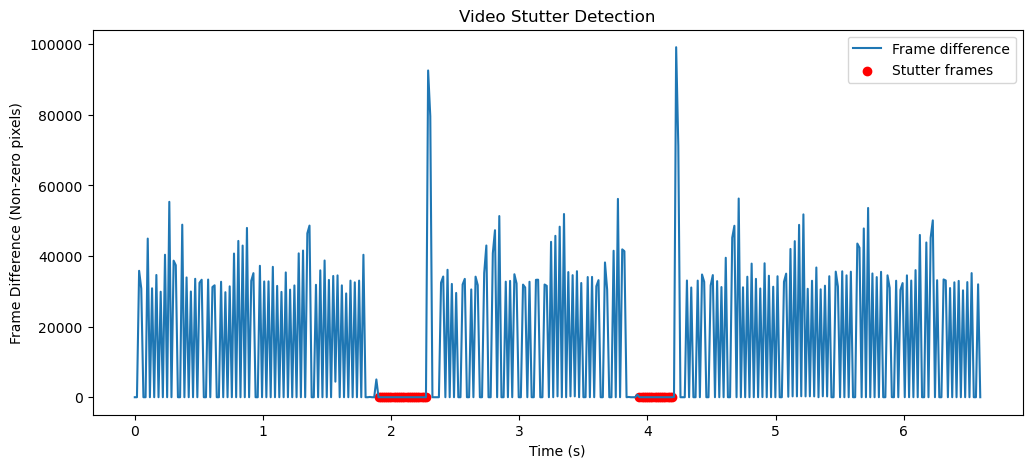

In [14]:
# -----------------------------------------------
# 実行例
# -----------------------------------------------

# Python では、この書き方をすると「このファイルを直接実行したときだけ、以下の処理を動かす」という意味
if __name__ == "__main__":  
    # list_video_devices 関数を呼んで、PCに接続されているカメラを探して、そのリストを devices に入れる
    devices = list_video_devices()
    if not devices:
        print("利用可能なカメラが見つかりませんでした")
    else:
        # launch_gui 関数を呼んで、どのカメラを使うか選ばせる　戻り値は選ばれたカメラのデバイス番号
        selected_device = launch_gui(devices)
        if selected_device is not None:
            print(f"選択されたデバイス番号: {selected_device}")
        else:
            print("カメラが選択されませんでした（GUIを閉じました）")

# 「カメラが選ばれたときだけキャプチャを開始する」 という安全策
    if selected_device is not None: 
        # start_capture 関数を呼び出して、選んだデバイス番号で映像キャプチャを開始※selected_device→device_number
        frames, stutter_frames, actual_fps = start_capture(selected_device)

        # 一時フォルダのパス
        temp_folder = os.path.join(os.path.expanduser("~"), "Desktop", "temp_frames")

        # 一時フォルダからフレームを読み込む
        frames = []
        for f in sorted(os.listdir(temp_folder)):
            if f.endswith(".png"):
                frames.append(cv2.imread(os.path.join(temp_folder, f)))

        # detect_stutter_auto_threshold 関数を呼び出して、frames の中からカクつきフレームを検出して、そのリストを stutter_frames に入れる
        stutter_frames = detect_stutter_auto_threshold(
            temp_folder=temp_folder,
            fps=actual_fps,
            min_time_diff=0.1,
            threshold_method='std'  # 必要に応じて k=2.0 なども指定
        )

        # plot_stutter 関数を呼び出して、frames と stutter_frames の情報をグラフに描画して、コマ落ちの有無やタイミングを可視化
        plot_stutter(frames, stutter_frames, fps=actual_fps)